### Analisis Finanzas 
#### Segundo desafio
¿Los clientes con préstamos e hipotecas tienden a tener un saldo medio más bajo o más riesgo de incumplimiento? ¿Cómo deberíamos ajustar nuestras ofertas y estrategias de gestión de riesgos en función de estos hallazgos?

#### Librerias y más

In [40]:
"""Librerías que pueden ser necesarias"""

# Manejo de datos
import pandas as pd                 # Análisis y manipulación de datos en tablas
import numpy as np                  # Cálculos numéricos y matrices
import os                           # Gestión de rutas de archivos
import re                           # Expresiones regulares para búsqueda y manipulación de texto

# Visualización de datos
import matplotlib.pyplot as plt     # Gráficos básicos en 2D
from matplotlib.ticker import FuncFormatter
import seaborn as sns               # Gráficos estadísticos mejorados
import plotly.express as px         # Gráficos interactivos simplificados
import plotly.graph_objects as go   # Control avanzado de gráficos en Plotly
import plotly.io as pio             # Interfaz de entrada/salida de Plotly
import squarify                     # Visualización de diagramas de "treemap"

# Procesado y análisis
from scipy import stats
from scipy.stats import chi2_contingency, norm, ttest_ind, f_oneway # Pruebas de hipótesis y análisis estadístico
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings("ignore")#ignorar advertencias

#Paleta de colores oficial
custom_palette = [ "#2CCED1", "#5F6F81", "#AABBC8", "#DCE3EA", "#2E2F36"]

#### Carga de datos

In [2]:
df = pd.read_csv('../Data/df_250519.csv')

#### Tabla relacion Prestamos e hipotecas
Se analiza si tiene prestamo, si tiene hipoteca, Saldo medio y tasa de incumplimiento

   Tiene préstamo  Tiene hipoteca  Saldo medio  Tasa incumplimiento  \
0           False           False  1844.047228             0.008864   
1           False            True  1365.205982             0.013876   
2            True           False   801.467991             0.057395   
3            True            True   773.169967             0.026403   

   Número de clientes  
0                7559  
1                6486  
2                 906  
3                1212  


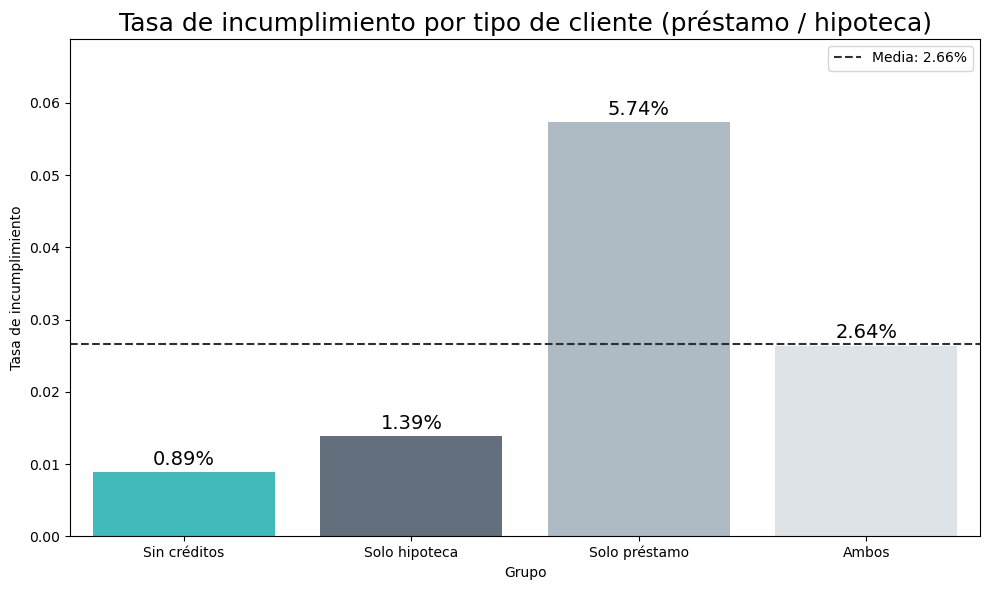

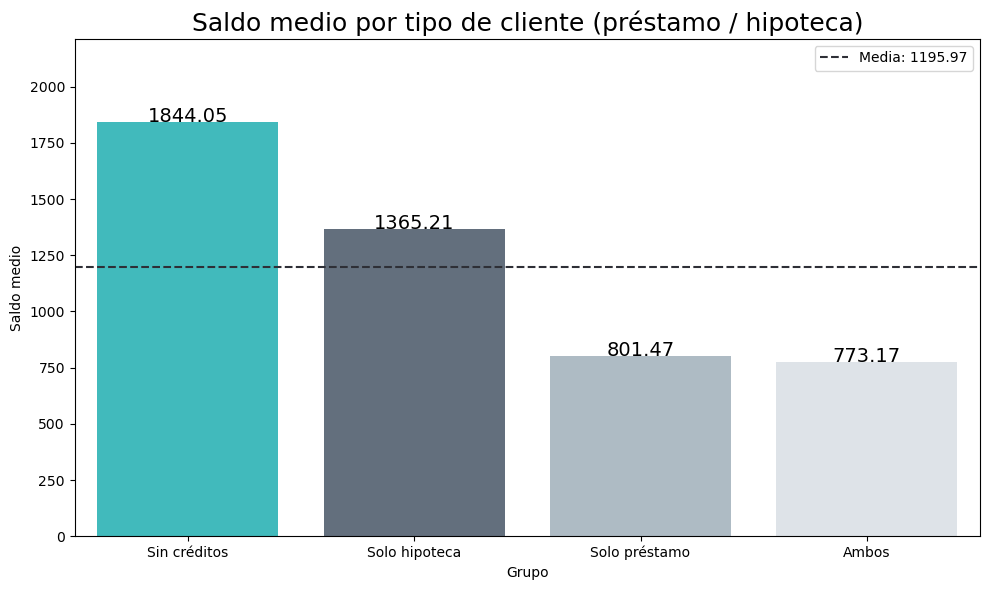

In [3]:
Tabla_agrupada = df.groupby(['loan', 'housing']).agg({'balance': 'mean','default': 'mean','id': 'count'}).reset_index()
Tabla_agrupada.columns = ['Tiene préstamo', 'Tiene hipoteca', 'Saldo medio', 'Tasa incumplimiento', 'Número de clientes'] 
print(Tabla_agrupada)

'''Esteos graficos se puede cambiar de orden para mostrarlos de manera inversa 
prestamo como Hue y hipoteca como x

sns.barplot(data=Tabla_agrupada, x='Tiene préstamo', y='Tasa incumplimiento', hue='Tiene hipoteca', palette=custom_palette)
plt.title("Tasa de incumplimiento por tipo de préstamo e hipoteca")
plt.ylabel("Tasa de incumplimiento")
plt.show()

sns.barplot(data=Tabla_agrupada, x='Tiene préstamo', y='Saldo medio', hue='Tiene hipoteca', palette=custom_palette)
plt.title("Saldo por tipo de préstamo e hipoteca")
plt.ylabel("Saldo")
plt.show()'''

# Barras combinadas tasa de incumplimiento
df_viz = Tabla_agrupada.copy()
def clasificar_cliente(row):
    if row['Tiene préstamo'] and row['Tiene hipoteca']:
        return "Ambos"
    elif row['Tiene préstamo'] and not row['Tiene hipoteca']:
        return "Solo préstamo"
    elif not row['Tiene préstamo'] and row['Tiene hipoteca']:
        return "Solo hipoteca"
    else:
        return "Sin créditos"
    
media_tasa = df_viz['Tasa incumplimiento'].mean()
media_saldo = df_viz['Saldo medio'].mean()
df_viz['Grupo'] = df_viz.apply(clasificar_cliente, axis=1)
# Ordenar los grupos
orden = ["Sin créditos", "Solo hipoteca","Solo préstamo", "Ambos" ]
df_viz['Grupo'] = pd.Categorical(df_viz['Grupo'], categories=orden, ordered=True)
df_viz = df_viz.sort_values('Grupo')

plt.figure(figsize=(10,6))
sns.barplot(x='Grupo', y='Tasa incumplimiento', data=df_viz, palette= custom_palette)

plt.title('Tasa de incumplimiento por tipo de cliente (préstamo / hipoteca)', fontsize=18)
plt.ylabel('Tasa de incumplimiento')
plt.ylim(0, df_viz['Tasa incumplimiento'].max()*1.2)

for idx, (_, row) in enumerate(df_viz.iterrows()):
    plt.text(idx, row['Tasa incumplimiento'] + 0.001, f"{row['Tasa incumplimiento']:.2%}", ha='center', fontsize=14)
plt.axhline(media_tasa, color="#2E2F36", linestyle='--', linewidth=1.5, label=f'Media: {media_tasa:.2%}')
plt.legend()
plt.tight_layout()
plt.show()

#barras combinadas saldo medio
orden2 = [ "Sin créditos", "Solo hipoteca","Solo préstamo", "Ambos"]
df_viz['Grupo'] = pd.Categorical(df_viz['Grupo'], categories=orden2, ordered=True)
df_viz = df_viz.sort_values('Grupo')
plt.figure(figsize=(10,6))  
sns.barplot(x='Grupo', y='Saldo medio', data=df_viz, palette= custom_palette)
plt.title('Saldo medio por tipo de cliente (préstamo / hipoteca)', fontsize=18)
plt.ylabel('Saldo medio')
plt.ylim(0, df_viz['Saldo medio'].max()*1.2)
for idx, (_, row) in enumerate(df_viz.iterrows()):
    plt.text(idx, row['Saldo medio'] + 0.001, f"{row['Saldo medio']:.2f}", ha='center', fontsize=14)
plt.axhline(media_saldo, color="#2E2F36", linestyle='--', linewidth=1.5, label=f'Media: {media_saldo:.2f}')
plt.legend()
plt.tight_layout()
plt.show()    

### Graficos de burbuja Finales

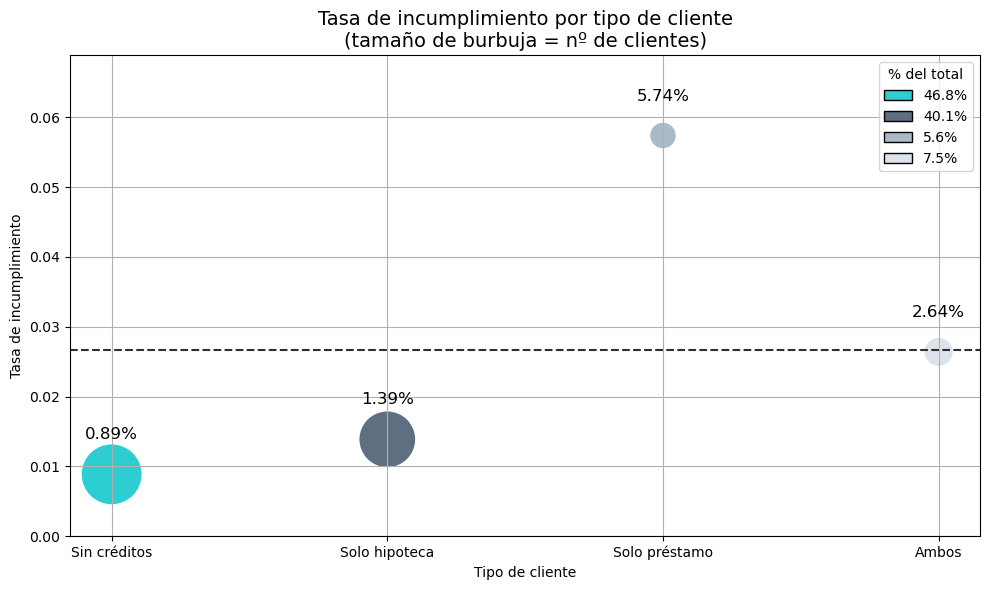

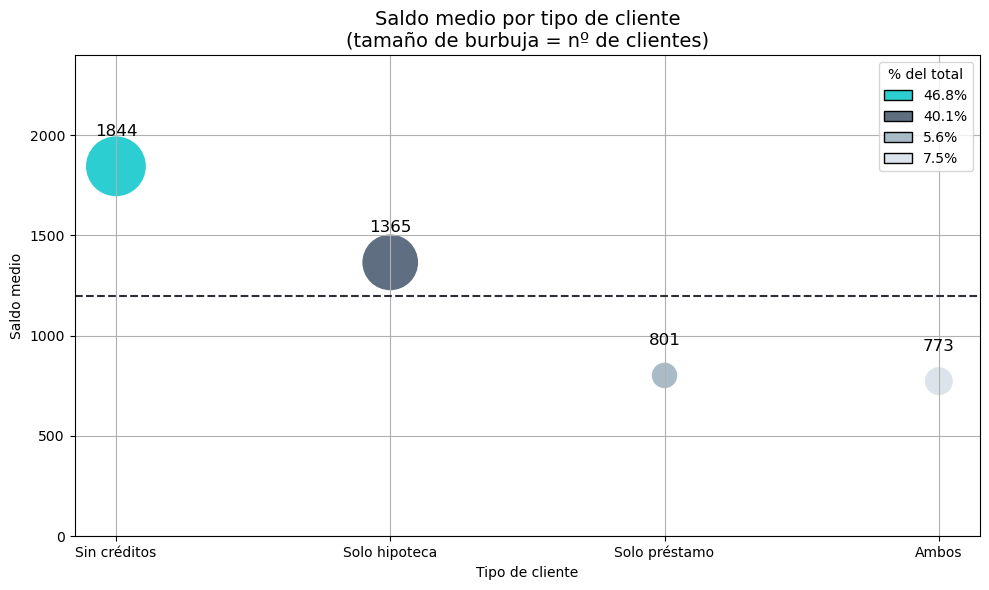

In [41]:
df_viz['Grupo'] = pd.Categorical(df_viz['Grupo'], categories=orden, ordered=True)
df_viz = df_viz.sort_values('Grupo')
media_tasa = df_viz['Tasa incumplimiento'].mean()
total_clientes = df_viz['Número de clientes'].sum()
df_viz['Porcentaje clientes'] = df_viz['Número de clientes'] / total_clientes

# Crear gráfico de burbujas para tasa de incumplimiento
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_viz,
    x='Grupo',
    y='Tasa incumplimiento',
    size='Número de clientes',
    hue='Grupo',
    sizes=(400, 2000),
    palette=custom_palette,
    legend=False,
)

# Agregar línea de media
plt.axhline(media_tasa, color="#2E2F36", linestyle='--', linewidth=1.5, label=f'Media: {media_tasa:.2%}')
# etiqueta sobre burbujas
for i, row in enumerate(df_viz.itertuples()):
    plt.text(i, row._4 + 0.005, f"{row._4:.2%}", ha='center', fontsize=12)

# Crear leyenda personalizada con colores y porcentajes
color_dict = dict(zip(df_viz['Grupo'], sns.color_palette(custom_palette)))
legend_elements = [
    Patch(
        facecolor=color_dict[row['Grupo']],
        edgecolor='black',
        label=f"{row['Porcentaje clientes']:.1%}"
    )
    for _, row in df_viz.iterrows()
]

# Mostrar leyenda personalizada
plt.legend(
    handles=legend_elements,
    title="% del total",
    loc='upper right'
)
plt.title("Tasa de incumplimiento por tipo de cliente\n(tamaño de burbuja = nº de clientes)", fontsize=14)
plt.xlabel("Tipo de cliente")
plt.ylabel("Tasa de incumplimiento")
plt.ylim(0, df_viz['Tasa incumplimiento'].max() * 1.2)
plt.tight_layout()
plt.grid(True)
plt.show()

# crear grafico de burbuja para saldo medio
df_viz['Grupo'] = pd.Categorical(df_viz['Grupo'], categories=orden2, ordered=True)
df_viz = df_viz.sort_values('Grupo')
plt.figure(figsize=(10,6))      
sns.scatterplot(
    data=df_viz,
    x='Grupo',
    y='Saldo medio',
    size='Número de clientes',
    hue='Grupo',
    sizes=(400, 2000),
    palette=custom_palette,
    legend=False,
)
# Agregar línea de media
plt.axhline(media_saldo, color="#2E2F36", linestyle='--', linewidth=1.5, label=f'Media: {media_saldo:.2f}')
# etiqueta sobre burbujas       
for i, row in enumerate(df_viz.itertuples()):
    plt.text(i, row._3 + 150, f"{row._3:.0f}", ha='center', fontsize=12)
# Crear leyenda personalizada con colores y porcentajes
color_dict = dict(zip(df_viz['Grupo'], sns.color_palette(custom_palette)))
legend_elements = [
    Patch(
        facecolor=color_dict[row['Grupo']],
        edgecolor='black',
        label=f"{row['Porcentaje clientes']:.1%}"
    )
    for _, row in df_viz.iterrows()
]
# Mostrar leyenda personalizada
plt.legend(
    handles=legend_elements,
    title="% del total",
    loc='upper right'
)
plt.title("Saldo medio por tipo de cliente\n(tamaño de burbuja = nº de clientes)", fontsize=14)
plt.xlabel("Tipo de cliente")
plt.ylabel("Saldo medio")
plt.ylim(0, df_viz['Saldo medio'].max()*1.3)
plt.tight_layout()
plt.grid(True)
plt.show()

#### ANOVA y t-test por pares

### Odds Ratio
chances de incumplimiento al tener un prestamo o hipoteca
La razón de momios (odds ratio) se calcula así:
odds ratio = odds de default en expuesto / odds de default en no expuestos.

donde :

odds de default en expuesto  = personas con inpago y con (prestamo, hipoteca) / personas sin inpago y con (prestamo, hipoteca)

odds de default en no expuestos = personas con inpago y sin (prestamo, hipoteca) / personas sin inpago y sin (prestamo, hipoteca)



#### Nota
use odds ratio en lugar de riesgo relativo pues tengo la intencion de hacer una regresion logistica si da tiempo

In [4]:
def odds_ratio(df, column_a, column_b):
    """Calcula la razón de probabilidades (odds ratio) entre dos grupos."""
    tabla_contingencia = pd.crosstab(df[column_a],df[column_b] )
    A= tabla_contingencia.iloc[1, 1] 
    B= tabla_contingencia.iloc[1, 0] 
    C= tabla_contingencia.iloc[0, 1]
    D= tabla_contingencia.iloc[0, 0]
    # Evitar divisiones por cero
    if B == 0 or D == 0:
        print("⚠️ Uno de los valores es cero, no se puede calcular la razón de momios.")
        return None
    odds_expuesto = A / B
    odds_no_expuesto = C / D
    odds_ratio = odds_expuesto /odds_no_expuesto
    print(f"📊 Tabla de contingencia entre '{column_a}' y '{column_b}':\n{tabla_contingencia}\n")
    print(f"odds_sin_{column_a}: {odds_expuesto}")
    print(f"odds_con_{column_a} : {odds_no_expuesto}")
    print(f"odds_ratio: {odds_ratio}")
    
# aplicar la función a los datos
odds_ratio(df, 'loan', 'default')
odds_ratio(df, 'housing', 'default')


📊 Tabla de contingencia entre 'loan' y 'default':
default  False  True 
loan                 
False    13888    157
True      2034     84

odds_sin_loan: 0.04129793510324484
odds_con_loan : 0.011304723502304147
odds_ratio: 3.6531574695150595
📊 Tabla de contingencia entre 'housing' y 'default':
default  False  True 
housing              
False     8346    119
True      7576    122

odds_sin_housing: 0.016103484688489968
odds_con_housing : 0.014258327342439491
odds_ratio: 1.1294091026061956


### Calculo del intervalo de confianza
calculado al 95% 

In [5]:
def calcular_odds_ratio_ic(df, columna_a, columna_b, alpha=0.05):
    tabla = pd.crosstab(df[columna_a], df[columna_b])
    
    # use true/false para evitar errores y confusiones
    A = tabla.loc[True, True]
    B = tabla.loc[True, False]  
    C = tabla.loc[False, True]
    D = tabla.loc[False, False]  
    odds_expuesto = A / B
    odds_no_expuesto = C / D
    OR = odds_expuesto /odds_no_expuesto

    # Log(OR) y error estándar
    log_or = np.log(OR) # logaritmo natural de la razón de momios
    se_log_or = np.sqrt(1/A + 1/B + 1/C + 1/D) # error estándar del logaritmo de la razón de momios
    # Intervalo de confianza
    z = norm.ppf(1 - alpha / 2) # valor crítico para el nivel de confianza
    lower = np.exp(log_or - z * se_log_or) # intervalo inferior
    upper = np.exp(log_or + z * se_log_or) # intervalo superior

    print(f"📊 Odds Ratio entre '{columna_a}' y '{columna_b}': {OR:.4f}")
    print(f"🔒 Intervalo de confianza {int((1-alpha)*100)}%: [{lower:.4f}, {upper:.4f}]")
    
    

# Aplicar la función a los datos
calcular_odds_ratio_ic(df, 'loan', 'default')
calcular_odds_ratio_ic(df, 'housing', 'default')

📊 Odds Ratio entre 'loan' y 'default': 3.6532
🔒 Intervalo de confianza 95%: [2.7915, 4.7808]
📊 Odds Ratio entre 'housing' y 'default': 1.1294
🔒 Intervalo de confianza 95%: [0.8757, 1.4566]


### Chi cuadrado
comprobar la relaciond variables categoricas

In [6]:
# Función para ejecutar Chi-cuadrado entre default y una variable categórica
def Funcion_Chi2(df, column):
    Tabla_contingencia = pd.crosstab(df[column], df['default'])
    chi2, p, dof, expected = chi2_contingency(Tabla_contingencia)
    print(f"\nTest Chi-cuadrado entre '{column}' y 'default'")
    print("Tabla de contingencia:\n", Tabla_contingencia)
    print(f"Chi2 = {chi2:.4f}, p-valor = {p:.4f}, grados de libertad = {dof}")
    if p < 0.05:
        print("❗Hay evidencia estadística de asociación entre las variables.")
    else:
        print("✅ No se detecta asociación estadísticamente significativa.")

# Aplicar a 'loan' y 'housing'
Funcion_Chi2(df, 'loan')
Funcion_Chi2(df, 'housing')


Test Chi-cuadrado entre 'loan' y 'default'
Tabla de contingencia:
 default  False  True 
loan                 
False    13888    157
True      2034     84
Chi2 = 99.7154, p-valor = 0.0000, grados de libertad = 1
❗Hay evidencia estadística de asociación entre las variables.

Test Chi-cuadrado entre 'housing' y 'default'
Tabla de contingencia:
 default  False  True 
housing              
False     8346    119
True      7576    122
Chi2 = 0.7622, p-valor = 0.3826, grados de libertad = 1
✅ No se detecta asociación estadísticamente significativa.


### Representación gráfica del saldo promedio por tipo de cliente en función de préstamos

In [7]:
saldo_medio_global = int(df['balance'].mean())

In [8]:
def categorize_credit(row):
    if not row['loan'] and not row['housing']:
        return 'Sin créditos'
    elif not row['loan'] and row['housing']:
        return 'Sólo hipoteca'
    elif row['loan'] and not row['housing']:
        return 'Sólo préstamo'
    else:
        return 'Ambos'

df['categoria_credito'] = df.apply(categorize_credit, axis=1)

# Agrupar y calcular promedio de balance
balance_promedio = df.groupby('categoria_credito')['balance'].mean().reindex(['Sin créditos', 'Sólo hipoteca', 'Sólo préstamo', 'Ambos'])
balance_promedio

categoria_credito
Sin créditos     1844.047228
Sólo hipoteca    1365.205982
Sólo préstamo     801.467991
Ambos             773.169967
Name: balance, dtype: float64

In [9]:
clientes_por_categoria = df['categoria_credito'].value_counts().reindex(['Sin créditos', 'Sólo hipoteca', 'Sólo préstamo', 'Ambos'])

# Crear DataFrame final
df_balance = pd.DataFrame({
    'balance_promedio': balance_promedio,
    'clientes_por_categoria': clientes_por_categoria
}).reset_index()

# Calcular porcentaje de clientes
total_clientes = clientes_por_categoria.sum()
df_balance['pct_clientes'] = (df_balance['clientes_por_categoria'] / total_clientes * 100).round(1)

df_balance

,categoria_credito,balance_promedio,clientes_por_categoria,pct_clientes
0,Sin créditos,1844.047228,7559,46.8
1,Sólo hipoteca,1365.205982,6486,40.1
2,Sólo préstamo,801.467991,906,5.6
3,Ambos,773.169967,1212,7.5


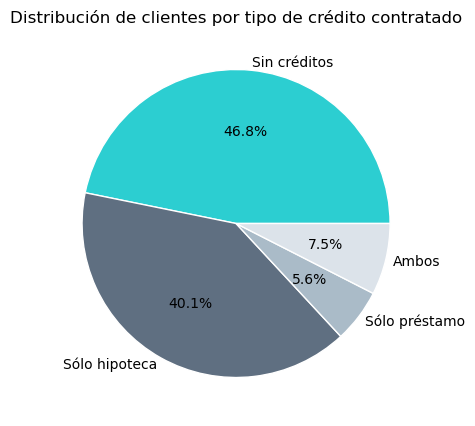

In [10]:
# Create a pieplot
plt.figure(figsize=(5, 5))
plt.pie(df_balance['pct_clientes'], labels=df_balance['categoria_credito'], labeldistance=1.05, autopct='%1.1f%%', colors=custom_palette, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' })
plt.title("Distribución de clientes por tipo de crédito contratado", loc='center')
plt.show()

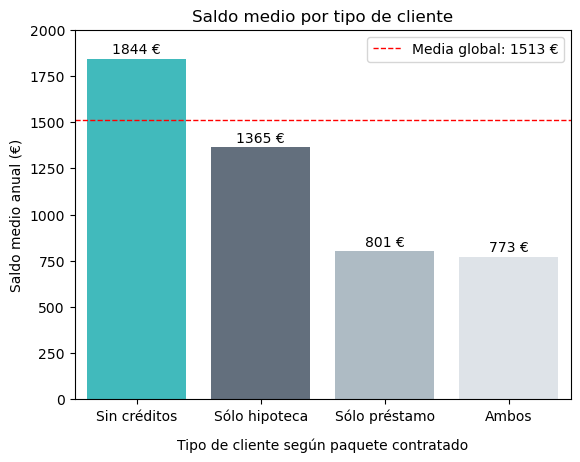

In [11]:
# Gráfica pandas
# balance_promedio.plot(kind='bar', color=custom_palette[:4])
# plt.xticks(rotation=0)

# Gráfica seaborn
df_balance = balance_promedio.reset_index()
df_balance.columns = ['Tipo de cliente', 'Saldo medio anual']

sns.barplot(data=df_balance, x='Tipo de cliente', y='Saldo medio anual', palette=custom_palette[:4])
plt.title("Saldo medio por tipo de cliente")
plt.ylabel("Saldo medio anual (€)")
plt.xlabel("Tipo de cliente según paquete contratado", labelpad=10)
plt.xticks(rotation=0)
plt.ylim(0, 2000)

# Línea punteada del saldo medio global
plt.axhline(saldo_medio_global, color='red', linestyle='--', linewidth=1, label=f"Media global: {saldo_medio_global} €")

# Añadir etiquetas en cada barra
for i, row in df_balance.iterrows():
    plt.text(i, row["Saldo medio anual"] + 10, f'{int(row["Saldo medio anual"])} €', color='black', ha='center', va='bottom')

plt.legend()
plt.show()

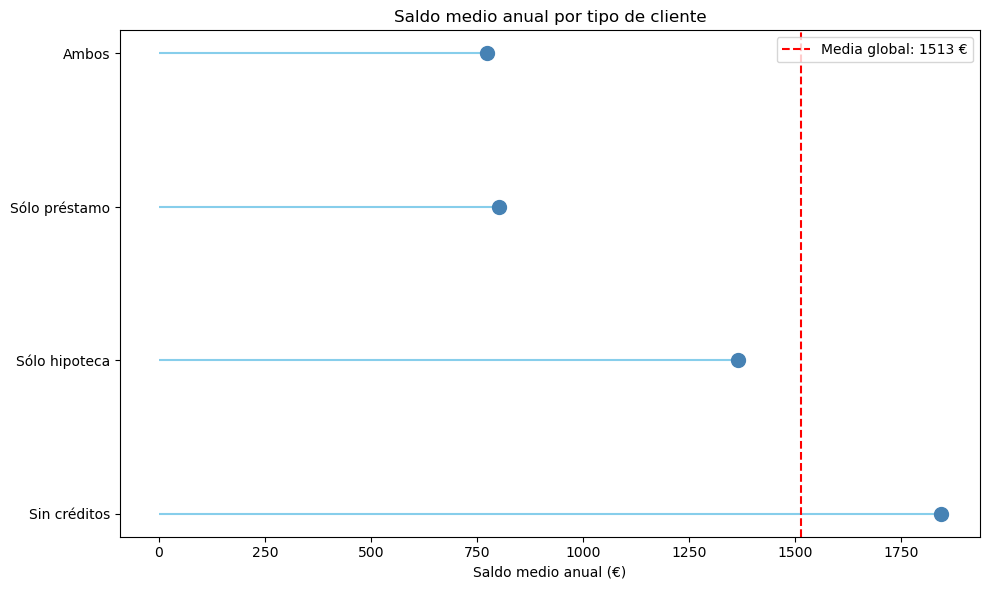

In [12]:
plt.figure(figsize=(10, 6))
plt.hlines(y=df_balance["Tipo de cliente"], xmin=0, xmax=df_balance["Saldo medio anual"], color='skyblue', linestyles='solid')
plt.plot(df_balance["Saldo medio anual"], df_balance["Tipo de cliente"], "o", markersize=10, color='steelblue')
plt.axvline(saldo_medio_global, color='red', linestyle='--', label=f"Media global: {saldo_medio_global} €")
plt.title("Saldo medio anual por tipo de cliente")
plt.xlabel("Saldo medio anual (€)")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

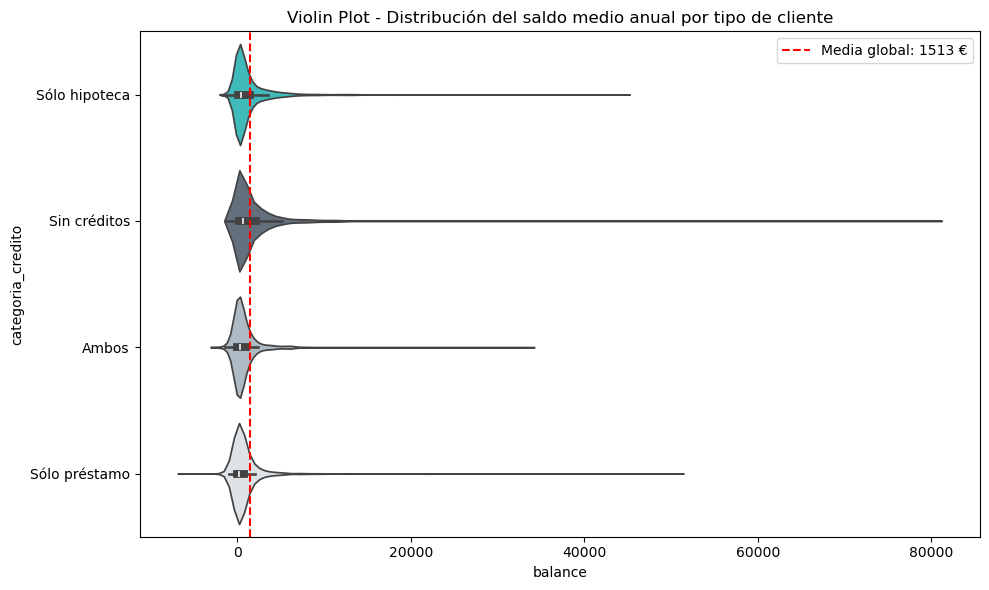

In [13]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x="balance", y="categoria_credito", palette=custom_palette[:4], cut=0)
plt.axvline(saldo_medio_global, color='red', linestyle='--', label=f"Media global: {saldo_medio_global} €")
plt.title("Violin Plot - Distribución del saldo medio anual por tipo de cliente")
plt.tight_layout()
plt.legend()
plt.show()

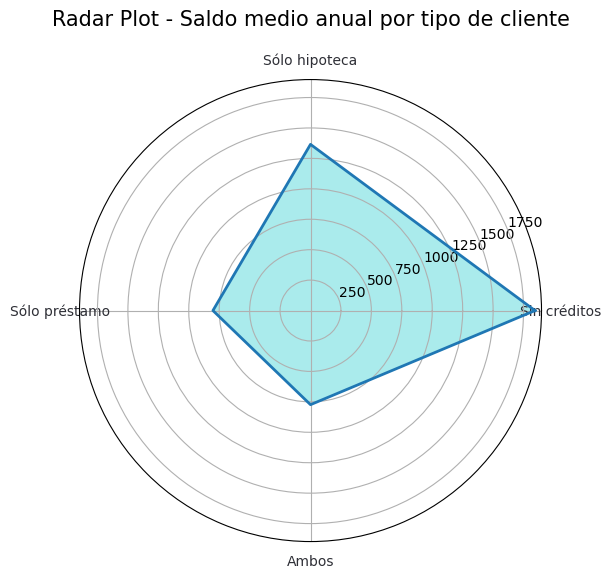

In [14]:
from math import pi

categories = df_balance["Tipo de cliente"].tolist()
values = df_balance["Saldo medio anual"].tolist()
values += values[:1]  # cerrar el radar

angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories, color='#2E2F36', size=10)
ax.plot(angles, values, linewidth=2, linestyle='solid')
ax.fill(angles, values, '#2CCED1', alpha=0.4)
plt.title("Radar Plot - Saldo medio anual por tipo de cliente", size=15, y=1.1)
plt.show()

In [15]:
print(df.info())
print(df['categoria_credito'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16163 entries, 0 to 16162
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         16163 non-null  int64 
 1   id                 16163 non-null  int64 
 2   age                16163 non-null  int64 
 3   job                16163 non-null  object
 4   marital            16163 non-null  object
 5   education          16163 non-null  object
 6   default            16163 non-null  bool  
 7   balance            16163 non-null  int64 
 8   housing            16163 non-null  bool  
 9   loan               16163 non-null  bool  
 10  contact            16163 non-null  object
 11  day                16163 non-null  int64 
 12  month              16163 non-null  object
 13  duration           16163 non-null  int64 
 14  campaign           16163 non-null  int64 
 15  pdays              16163 non-null  int64 
 16  previous           16163 non-null  int64

- *Clientes sin créditos tienen el saldo medio anual más alto (alrededor de 1850 €)*
- *Clientes con sólo hipoteca tienen un saldo medio intermedio (aproximadamente 1350 €)*
- *Clientes con sólo préstamo y clientes con préstamo e hipoteca (ambos) tienen los saldos más bajos (por debajo de 800 €)*

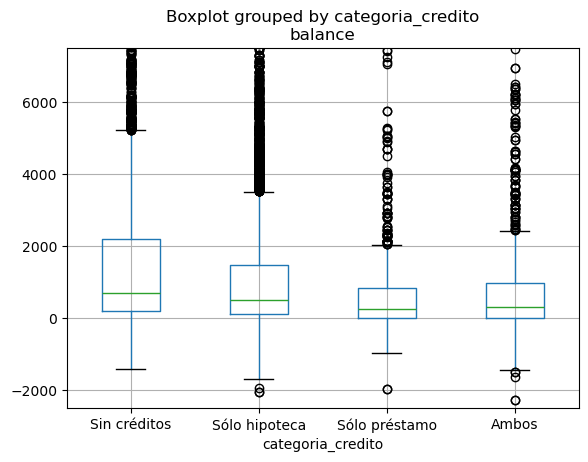

In [16]:
orden_categorias = ['Sin créditos', 'Sólo hipoteca', 'Sólo préstamo', 'Ambos']

# Asegura que la columna en df es categórica y ordenada
df['categoria_credito'] = pd.Categorical(df['categoria_credito'], categories=orden_categorias, ordered=True)

df.boxplot(column='balance', by='categoria_credito')
plt.ylim(-2500, 7500)
plt.show()

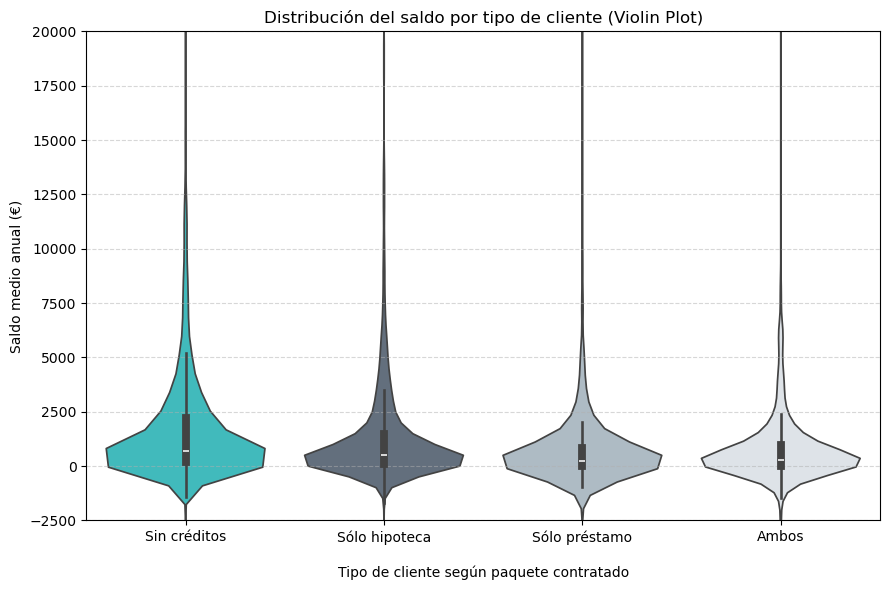

In [17]:
# Aseguramos orden y tipo categórico
orden_categorias = ['Sin créditos', 'Sólo hipoteca', 'Sólo préstamo', 'Ambos']
df['categoria_credito'] = pd.Categorical(df['categoria_credito'], categories=orden_categorias, ordered=True)

# Violinplot con estética y paleta personalizada
plt.figure(figsize=(9, 6))
sns.violinplot(data=df, x='categoria_credito', y='balance', palette=custom_palette[:4], inner='box')

plt.title("Distribución del saldo por tipo de cliente (Violin Plot)")
plt.ylabel("Saldo medio anual (€)")
plt.xlabel("Tipo de cliente según paquete contratado", labelpad=15)
plt.ylim(-2500, 20000)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

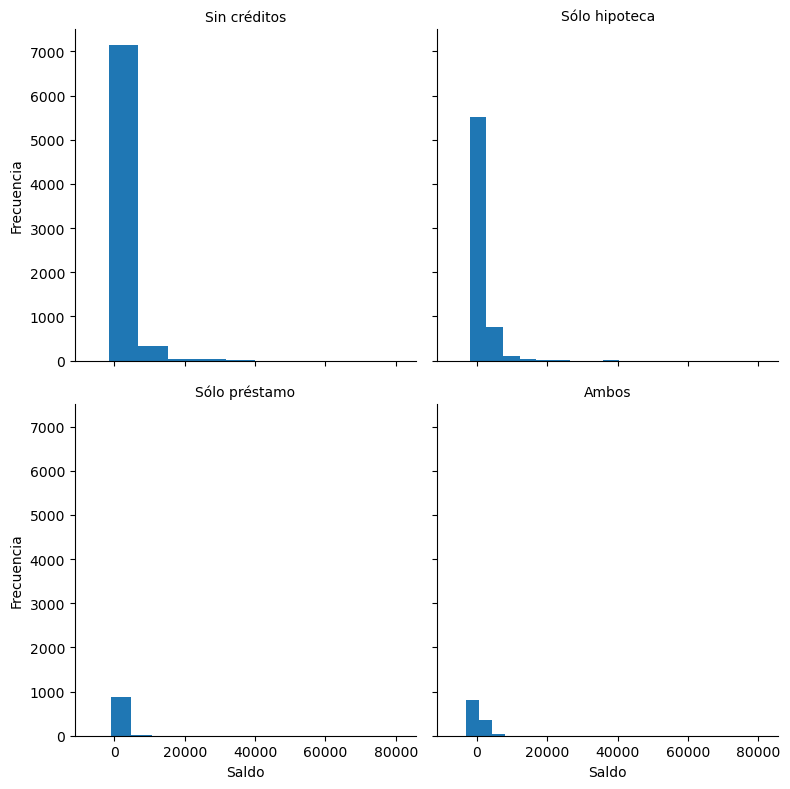

In [18]:
# Facetgrid con histogramas
g = sns.FacetGrid(df, col='categoria_credito', col_wrap=2, height=4, sharex=True, sharey=True)
g.map(plt.hist, 'balance', bins=10)

g.set_titles(col_template='{col_name}')
g.set_axis_labels('Saldo', 'Frecuencia')
plt.tight_layout()
plt.show()

In [19]:
treemap_df = df.groupby("categoria_credito")["balance"].agg(["count", "mean", "sum"]).reset_index()
fig_treemap = px.treemap(treemap_df, 
                         path=["categoria_credito"], 
                         values="count", 
                         color="mean", 
                         color_continuous_scale="RdBu", 
                         title="Distribución de Clientes y Saldo Medio por Categoría de Crédito")
fig_treemap.show()

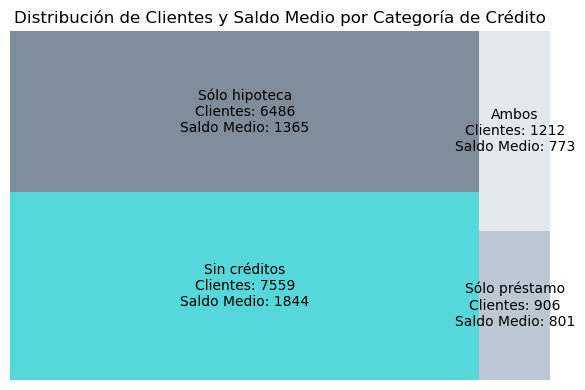

In [20]:
# Preparar los datos para squarify
labels = treemap_df["categoria_credito"].astype(str) + "\n" + \
         "Clientes: " + treemap_df["count"].astype(str) + "\n" + \
         "Saldo Medio: " + treemap_df["mean"].round(0).astype(int).astype(str)

sizes = treemap_df["count"]
colors = treemap_df["mean"]

# Crear el gráfico
plt.figure(figsize=(6, 4))
squarify.plot(sizes=sizes, label=labels, color=custom_palette, alpha=0.8)
plt.axis('off')
plt.title("Distribución de Clientes y Saldo Medio por Categoría de Crédito")
plt.tight_layout()
plt.show()

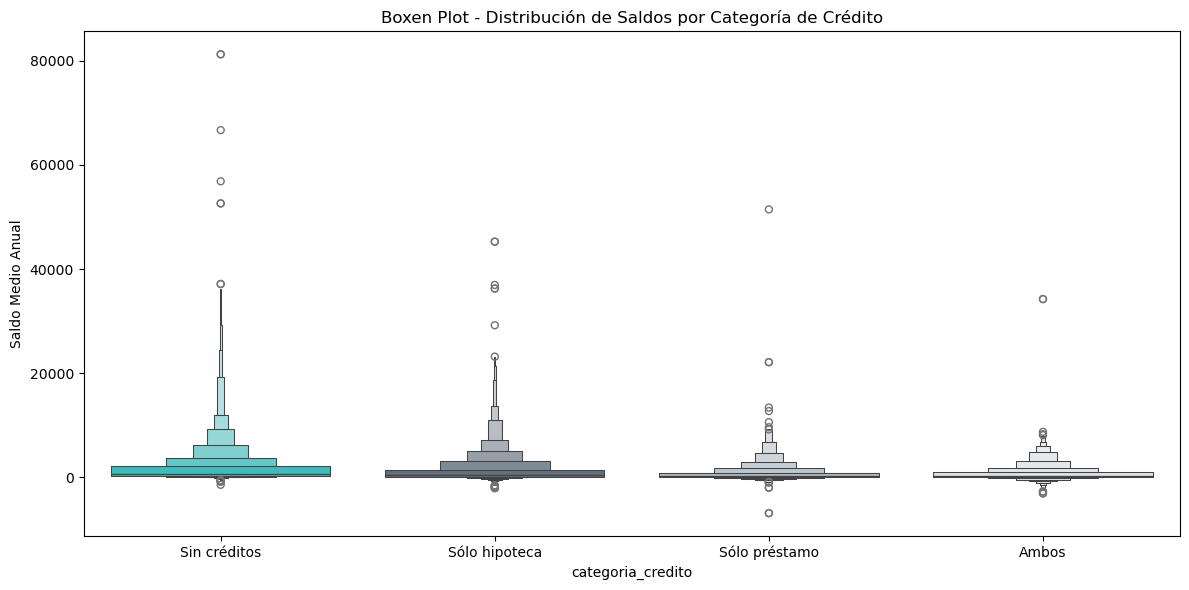

In [21]:
plt.figure(figsize=(12, 6))
sns.boxenplot(data=df, x="categoria_credito", y="balance", palette=custom_palette[:4])
plt.title("Boxen Plot - Distribución de Saldos por Categoría de Crédito")
plt.ylabel("Saldo Medio Anual")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [22]:
# Obtener los grupos
grupo_sin_creditos = df[df['categoria_credito'] == 'Sin créditos']['balance']
grupo_solo_hipoteca = df[df['categoria_credito'] == 'Sólo hipoteca']['balance']
grupo_solo_prestamo = df[df['categoria_credito'] == 'Sólo préstamo']['balance']
grupo_ambos = df[df['categoria_credito'] == 'Ambos']['balance']

# ANOVA (comparar medias de los cuatro grupos)
anova_result = f_oneway(grupo_sin_creditos, grupo_solo_hipoteca, grupo_solo_prestamo, grupo_ambos)

# T-Tests pareados (entre grupos específicos)
ttest_1 = ttest_ind(grupo_sin_creditos, grupo_solo_hipoteca, equal_var=False)
ttest_2 = ttest_ind(grupo_sin_creditos, grupo_solo_prestamo, equal_var=False)
ttest_3 = ttest_ind(grupo_sin_creditos, grupo_ambos, equal_var=False)
ttest_4 = ttest_ind(grupo_solo_hipoteca, grupo_solo_prestamo, equal_var=False)
ttest_5 = ttest_ind(grupo_solo_hipoteca, grupo_ambos, equal_var=False)
ttest_6 = ttest_ind(grupo_solo_prestamo, grupo_ambos, equal_var=False)

p_value_significativo = 0.05

resultados = {
    "ANOVA p-value": anova_result.pvalue,
    "T-test Sin créditos vs Sólo hipoteca": ttest_1.pvalue,
    "T-test Sin créditos vs Sólo préstamo": ttest_2.pvalue,
    "T-test Sin créditos vs Ambos": ttest_3.pvalue,
    "T-test Sólo hipoteca vs Sólo préstamo": ttest_4.pvalue,
    "T-test Sólo hipoteca vs Ambos": ttest_5.pvalue,
    "T-test Sólo préstamo vs Ambos": ttest_6.pvalue
}

for nombre, pvalor in resultados.items():
    es_significativo = "Significativo" if pvalor < p_value_significativo else "No significativo"
    print(f"{nombre}: p = {pvalor:.3e} → {es_significativo}")

ANOVA p-value: p = 1.723e-46 → Significativo
T-test Sin créditos vs Sólo hipoteca: p = 3.116e-19 → Significativo
T-test Sin créditos vs Sólo préstamo: p = 6.586e-29 → Significativo
T-test Sin créditos vs Ambos: p = 1.922e-51 → Significativo
T-test Sólo hipoteca vs Sólo préstamo: p = 2.092e-10 → Significativo
T-test Sólo hipoteca vs Ambos: p = 1.744e-19 → Significativo
T-test Sólo préstamo vs Ambos: p = 7.742e-01 → No significativo


*Resultado*
- Casi todos los grupos tienen diferencias de saldo estadísticamente significativas entre sí, excepto:
    - Clientes con "Sólo préstamo" vs "Ambos" no muestran diferencias claras → sus saldos medios son estadísticamente similares.
    - **Aunque los clientes con hipoteca + p´restamo puedan parecer más endeudados, su saldo anual no es significativamente diferente de los clientes que solo tienen préstamo**
    - **tener hipoteca adicional no implica un saldo más bajo**

Propuestas:
Ya que el impacto de tener una hipoteca adicional no reduce el saldo:
- Ofrecer hipotecas a clientes con préstamo personal sin asumir menor capacidad de pago.
- Ofrecer consolidación de deuda o refinanciación conjunta a quienes tienen ambos productos.
- No penalizar automáticamente a quienes tienen ambos productos asumiendo sobreendeudamiento.
- Ajustar el modelo de riesgo si el saldo medio y el comportamiento de pagos es similar entre estos dos grupos.

# KPIs

- saldo medio gral
- saldo medio por decil
- % clientes por tasa de riesgo
- % clientes con hipoteca
- % clientes con préstamo
- % clientes con hipoteca + préstamo
- tasa contratación depósito
- tasa incumplimiento
- probabilidad de incumplimiento global

In [23]:
df['month'].unique()

array(['May', 'Jun', 'Jul', 'Aug', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb',
       'Mar', 'Apr', 'Sep'], dtype=object)

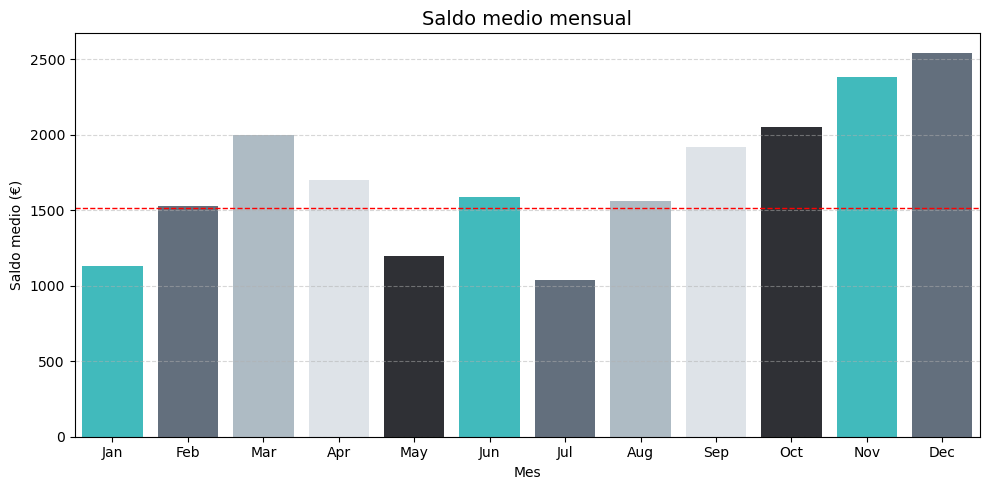

In [24]:
orden_meses = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

saldo_medio_mensual = df['balance'].groupby(df['month']).mean().reset_index()
saldo_medio_mensual['month'] = pd.Categorical(saldo_medio_mensual['month'], categories=orden_meses, ordered=True)
saldo_medio_mensual = saldo_medio_mensual.sort_values('month')

plt.figure(figsize=(10, 5))
sns.barplot(data=saldo_medio_mensual, x='month', y='balance', palette=custom_palette)
plt.axhline(saldo_medio_global, color='red', linestyle='--', linewidth=1, label=f"Media global: {saldo_medio_global} €")
plt.title("Saldo medio mensual", fontsize=14)
plt.ylabel("Saldo medio (€)")
plt.xlabel("Mes")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

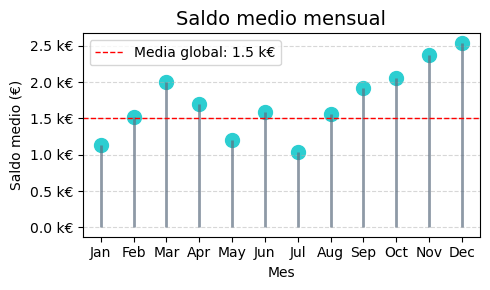

In [25]:
# Función para formatear en k€
def euros_k(x, _):
    return f'{x / 1000:.1f} k€'

plt.figure(figsize=(5, 3))

# Dibujamos las líneas verticales
plt.vlines(x=saldo_medio_mensual['month'], ymin=0, ymax=saldo_medio_mensual['balance'], color='#5F6F81', alpha=0.7, linewidth=2)

# Dibujamos los puntos
plt.scatter(x=saldo_medio_mensual['month'], y=saldo_medio_mensual['balance'], color='#2CCED1', s=100)

# Línea de media global (si ya la tienes definida como 'saldo_medio_global')
plt.axhline(saldo_medio_global, color='red', linestyle='--', linewidth=1,
            label=f"Media global: {saldo_medio_global / 1000:.1f} k€")
# Estética
plt.title("Saldo medio mensual", fontsize=14)
plt.ylabel("Saldo medio (€)")
plt.xlabel("Mes")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.gca().yaxis.set_major_formatter(FuncFormatter(euros_k))
plt.tight_layout()
plt.legend()
plt.show()

In [26]:
# Saldo medio general
saldo_medio_global = df['balance'].mean()
print(round((saldo_medio_global/1000),1), "k€")

1.5 k€


In [27]:
# % de clientes con hipoteca
con_hipoteca = df['housing'].value_counts().get(True)
total = len(df['housing'])

hipoteca_pct = 100 * con_hipoteca / total
print(f"{hipoteca_pct:.2f}%")

47.63%


In [28]:
# % de clientes con préstamo
con_prestamo = df['loan'].value_counts().get(True)
total = len(df['loan'])

prestamo_pct = 100 * con_prestamo / total
print(f"{prestamo_pct:.2f}%")

13.10%


In [29]:
# % de clientes con ambos
con_ambos = len(df[df['loan'] & df['housing']])
total = len(df)

ambos_pct = 100 * con_ambos / total
print(f"{ambos_pct:.2f}%")

7.50%


In [30]:
# % contratacion deposito
contratan = df['deposit'].value_counts().get(True)
total = len(df['deposit'])

deposito_pct = 100 * contratan / total
print(f"{deposito_pct:.2f}%")

47.71%


In [31]:
# % de incumplimiento global
pd_global = df['default'].mean()
print("PD global =", (pd_global*100).round(2), "%")

PD global = 1.49 %


In [32]:
# Crear deciles y calcular métricas de riesgo
df['balance_decile'] = pd.qcut(df['balance'], q=10, labels=False)
default_rates = (
    df.groupby('balance_decile')['default']
    .agg(['mean', 'count'])
    .reset_index()
    .rename(columns={'mean': 'default', 'count': 'clientes'})
)
default_rates['balance_decile'] += 1
default_rates['default'] = default_rates['default'].round(4)
default_rates['indice_riesgo'] = (default_rates['default'] / pd_global).round(2)

# Calcular porcentaje de clientes por decil
clientes_totales = len(df)
default_rates['porcentaje_clientes'] = (default_rates['clientes'] / clientes_totales * 100).round(2)

# Clasificar nivel de riesgo
def categorize_risk(rate):
    return (
        'Muy alto' if rate > 0.10 else
        'Alto'     if rate > 0.05 else
        'Moderado' if rate > 0.02 else
        'Bajo'
    )

default_rates['risk_level'] = default_rates['default'].apply(categorize_risk)

# Porcentaje de clientes por categoría de riesgo
porcentaje_riesgo = (
    default_rates.groupby('risk_level')['porcentaje_clientes']
    .sum()
    .reindex(['Muy alto', 'Alto', 'Moderado', 'Bajo'])
    .reset_index()
)
porcentaje_riesgo['porcentaje_clientes'] = porcentaje_riesgo['porcentaje_clientes'].fillna(0).astype(int)
porcentaje_riesgo

,risk_level,porcentaje_clientes
0,Muy alto,0
1,Alto,13
2,Moderado,6
3,Bajo,79


# Regresión lineal para ver cómo afectan `housing` y `loan` al `balance`

In [33]:
# Copia de las columnas del df que voy a necesitar
df2 = df[['id','default', 'balance', 'housing', 'loan']].copy()
df2.head()

,id,default,balance,housing,loan
0,1,False,2343,True,False
1,2,False,2343,True,False
2,3,False,45,False,False
3,4,False,1270,True,False
4,5,False,2476,True,False


In [34]:
# Convierto los booleanos a variables binarias
df2[['default', 'housing', 'loan']].astype(int)

,default,housing,loan
0,0,1,0
1,0,1,0
2,0,0,0
3,0,1,0
4,0,1,0
...,...,...,...
16158,0,0,0
16159,0,1,0
16160,1,1,0
16161,0,0,0


In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [36]:
# Definir variables predictoras y objetivo
X = df2[['housing', 'loan']].astype(int)
y = df2['balance']

# Separar datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo
model = LinearRegression()
model.fit(X, y)

# Coeficientes
pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': model.coef_
})

,Variable,Coeficiente
0,housing,-420.579545
1,loan,-791.195527


Cada variable tiene un coeficiente que indica el impacto que tienen sobre la variable dependiente (`balance`).
- Housing: -420,6 €
    > Tener hipoteca se asocia con un saldo anual promedio de unos 420€ menos que no tenerla
- Loan: 791,2 €
    > Tener un préstamos personal se asocia con un saldo anual promedio 791€ menos

In [37]:
from sklearn.metrics import r2_score

y_pred = model.predict(X)
r2_manual = r2_score(y, y_pred)
print(f"R² manual: {r2_manual:.4f}")

R² manual: 0.0127


Del valor de R2 podemos obtener que este modelo solo explica el 1,27% de los datos, pero no explica la estadística

In [38]:
model = sm.OLS(y, X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                balance   R-squared (uncentered):                   0.064
Model:                            OLS   Adj. R-squared (uncentered):              0.064
Method:                 Least Squares   F-statistic:                              552.3
Date:                Tue, 27 May 2025   Prob (F-statistic):                   9.71e-233
Time:                        11:34:48   Log-Likelihood:                     -1.5417e+05
No. Observations:               16163   AIC:                                  3.083e+05
Df Residuals:                   16161   BIC:                                  3.084e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Prob (F-statistic): si es < 0.05, significa que al menos una variable del modelo es significativa.